In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepc as qem

Cost after step     5:  1.7106216
Cost after step    10:  0.3279839
Cost after step    15:  0.2027891
Cost after step    20:  0.0771358
Cost after step    25:  0.0978982
Cost after step    30:  0.0243311
Cost after step    35:  0.1000270
Cost after step    40:  0.0278118
Cost after step    45:  0.0211424
Cost after step    50:  0.0730308
Cost after step    55:  0.0306076
Cost after step    60:  0.0847195
Cost after step    65:  0.0593839
Cost after step    70:  0.0417229
Cost after step    75:  0.1106781
Cost after step    80:  0.0939000
Cost after step    85:  0.0874818
Cost after step    90:  0.0489692
Cost after step    95:  0.0631355
Cost after step   100:  0.0404978
Optimized rotation angles: [[[ 0.28489617  1.55670882  0.00825174]
  [ 0.51952744  1.626568   -0.21625685]]

 [[ 0.21671975  1.51423945  0.86011443]
  [ 0.09151933  0.23574292  0.69300469]]]


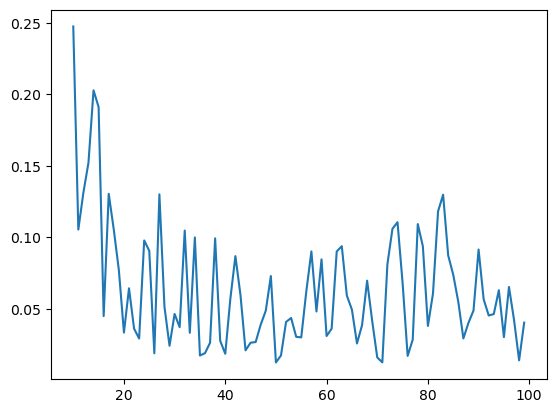

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
nqubitsdepolarizingchannel = nqubitschannel.nqubitsdepolarizingchannel(0.9)

@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (train_cir_without_qem(x) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

Cost after step     5:  1.1214662
Cost after step    10:  0.2475044
Cost after step    15:  0.1108142
Cost after step    20:  0.0721281
Cost after step    25:  0.0557377
Cost after step    30:  0.0471179
Cost after step    35:  0.0419580
Cost after step    40:  0.0385960
Cost after step    45:  0.0362726
Cost after step    50:  0.0345968
Cost after step    55:  0.0333487
Cost after step    60:  0.0323959
Cost after step    65:  0.0316544
Cost after step    70:  0.0310682
Cost after step    75:  0.0305991
Cost after step    80:  0.0302197
Cost after step    85:  0.0299102
Cost after step    90:  0.0296560
Cost after step    95:  0.0294460
Cost after step   100:  0.0292715
Optimized rotation angles: [[[ 0.04014756  1.46743126  0.02602476]
  [ 0.97504404  2.29677635 -0.05119943]]

 [[ 0.07477022  0.84361499  0.13326799]
  [ 0.91633113  0.05756114  0.34095069]]]


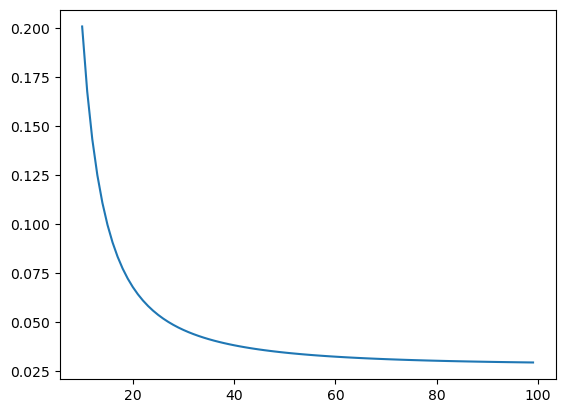

In [3]:
# We set the noise channel as time-invariant and observe the results again.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
nqubitsdepolarizingchannel = nqubitschannel.nqubitsdepolarizingchannel(0.9)

@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (train_cir_without_qem(x) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [4]:
# We estimate the total noise 'p_t' using the QEMZMSEPC method,
# allowing us to incorporate noise 'p_t' into the definition of the Loss function,
# thereby mitigating the impact of noise on quantum machine learning tasks.

operations = ['RX', 'RY', 'RZ', 'RX', 'RY', 'RZ', 'CNOT', 'CNOT',
              'RX', 'RY', 'RZ', 'RX', 'RY', 'RZ', 'CNOT', 'CNOT']
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)
w = weights.copy().reshape(-1)
paras = [[0, w[0]], [0, w[1]], [0, w[2]], [0, w[3]], [0, w[4]], [0, w[5]], [0, 1], [1, 0],
     [0, w[6]], [0, w[7]], [0, w[8]], [0, w[9]], [0, w[10]], [0, w[11]], [0, 1], [1, 0]]
qemzmsepc = qem.QEMZMSEPC(n_qubits)
_, p_t = qemzmsepc.qemzmsepc(operations=operations, paras=paras, dev=dev, p=0.9,
                         kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
print(p_t)

0.831676172404477


Cost after step     5:  1.1351917
Cost after step    10:  0.1828173
Cost after step    15:  0.0596478
Cost after step    20:  0.0282677
Cost after step    25:  0.0162579
Cost after step    30:  0.0104968
Cost after step    35:  0.0073145
Cost after step    40:  0.0053795
Cost after step    45:  0.0041181
Cost after step    50:  0.0032515
Cost after step    55:  0.0026310
Cost after step    60:  0.0021719
Cost after step    65:  0.0018229
Cost after step    70:  0.0015514
Cost after step    75:  0.0013361
Cost after step    80:  0.0011626
Cost after step    85:  0.0010207
Cost after step    90:  0.0009033
Cost after step    95:  0.0008049
Cost after step   100:  0.0007217
Optimized rotation angles: [[[0.64493077 0.18319895 0.77742364]
  [0.49110929 0.05861019 0.63790516]]

 [[0.877499   2.91623578 0.07059148]
  [0.48751715 0.01909662 0.1100425 ]]]


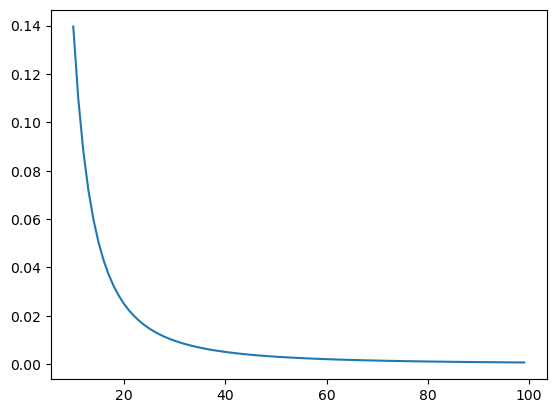

In [5]:
@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

# We modify the definition of the Loss function
# by dividing the output of the quantum circuit by the noise parameter p_t
# to obtain the expected output of the quantum circuit after error mitigation,
# and then proceed with the Loss calculation.

def cost(x):
    return ((train_cir_with_qem(x) / p_t) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []
qemzmsepc = qem.QEMZMSEPC(n_qubits)

for i in range(steps):
    params = opt.step(cost, params)
    w = params.copy().reshape(-1)
    paras = [[0, w[0]], [0, w[1]], [0, w[2]], [0, w[3]], [0, w[4]], [0, w[5]], [0, 1], [1, 0],
         [0, w[6]], [0, w[7]], [0, w[8]], [0, w[9]], [0, w[10]], [0, w[11]], [0, 1], [1, 0]]
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    _, p_t = qemzmsepc.qemzmsepc(operations=operations, paras=paras, dev=dev, p=0.9,
                             kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))
import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [6]:
# From the results, we can observe that the Loss function exhibits a stable decreasing trend
# after error mitigation through the QEMZMSEPC scheme,
# and ultimately, the outcome is better than without error mitigation.